## Experimental Workflow Summary

This notebook simulates a full-scale A/B testing workflow in Python, comparing conversion rates between two digital experiences — Variant Alpha (control group) and Variant Beta (treatment group). The aim is to apply rigorous statistical analysis to evaluate which version performs better.

### Objective

To determine whether Variant Beta shows a statistically significant improvement in user conversion compared to Variant Alpha by modeling purchase behavior and applying formal hypothesis testing.

### Analytical Strategy

- **Synthetic Data Simulation**  
  Uses binomial sampling to emulate real-world conversion behavior under controlled probability assumptions for each variant. This avoids reliance on live traffic and supports preliminary decision-making.

- **Conversion Estimation with Confidence Intervals**  
  Calculates observed conversion rates and constructs 95% confidence intervals to express uncertainty. This accounts for sample size and outcome variability.

- **Visual Analysis with Error Bars**  
  Generates comparative bar charts to illustrate conversion performance and margin of error. This aids stakeholder communication and highlights potential overlap in statistical ranges.

- **Hypothesis Testing with Z-Score**  
  Applies a two-proportion Z-test to validate whether observed differences are statistically significant or due to chance. Outputs include p-value interpretation and rejection of the null hypothesis if thresholds are met.

- **Sequential Monitoring Simulation**  
  Models batch-wise arrival of traffic and re-evaluates metrics after each wave. Tracks evolving uplift and p-value trends, illustrating convergence over time and supporting adaptive experimental decisions.

### Libraries Used

| Library      | Purpose                                                     |
|--------------|-------------------------------------------------------------|
| Python       | Base scripting language for computation and control flow    |
| NumPy        | Probabilistic modeling and synthetic data generation        |
| Pandas       | Tabular data handling and summary statistics                |
| SciPy        | Confidence interval computation and statistical functions   |
| Statsmodels  | Execution of z-tests for difference in proportions          |
| Matplotlib   | Data visualization, trend plots, and statistical graphics   |

### Workflow Breakdown

1. **Synthetic Data Generation**  
   Simulate user purchase decisions for both variants using binomial models. Assign realistic sample sizes and conversion probabilities to mimic actual traffic behavior.

2. **Conversion Rate Calculation**  
   Determine sample conversion rates and apply normal approximation techniques to construct confidence intervals. These intervals convey reliability of observed performance.

3. **Visualization of Results**  
   Create structured bar plots with error bars to compare metrics. Highlights confidence overlap and helps assess practical significance.

4. **Statistical Significance Test**  
   Perform a two-proportion z-test to examine whether Beta outperforms Alpha. Includes z-score derivation, p-value calculation, and decision thresholds.

5. **Sequential Traffic Simulation**  
   Evaluate results in real-time by simulating incoming traffic in batches. Update metrics and plot dynamic uplift and statistical power over time to mimic ongoing experiments.



**1. Data Simulation for A/B Test**

## Step 1: Constructing Simulated User Behavior Data

This phase initiates a controlled simulation to compare two digital variants — Segment R (reference) and Segment S (test). Each group is exposed to a theoretical traffic of **8,500 users**. Segment R is modeled with a **conversion probability of 11.2%**, while Segment S is set at **13.6%**, representing a presumed uplift of 2.4%.

Rather than assigning fixed conversion counts, the model embraces uncertainty by simulating actual user decisions using a binomial process through NumPy’s `np.random.binomial()` function. This reflects the way real consumers behave: some convert, others don’t, regardless of expected averages.

For instance, one simulation run might produce **945 conversions** for Segment R and **1,156 conversions** for Segment S. These counts fluctuate across trials, acknowledging behavioral randomness and offering a foundation for credible statistical inference.

Building simulated datasets in this way helps product teams visualize the impact of their design decisions before actual deployment. It allows for rigorous analysis within a risk-free environment—ideal for refining interfaces, call-to-action placements, or funnel optimizations before subjecting users to live experiments.


In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

# Set random seed for reproducibility
np.random.seed(21)

# Hypothetical user traffic and conversion probabilities
segment_R_visitors, segment_S_visitors = 8500, 8500
segment_R_rate, segment_S_rate = 0.112, 0.136  # Segment R: 11.2%, Segment S: 13.6% conversion

# Simulate actual conversion outcomes via binomial distribution
segment_R_hits = np.random.binomial(segment_R_visitors, segment_R_rate)
segment_S_hits = np.random.binomial(segment_S_visitors, segment_S_rate)

# Print simulated conversion counts
print(f"Segment R: {segment_R_hits} conversions out of {segment_R_visitors} visitors")
print(f"Segment S: {segment_S_hits} conversions out of {segment_S_visitors} visitors")


Segment R: 939 conversions out of 8500 visitors
Segment S: 1219 conversions out of 8500 visitors


**2. Conversion Rate & 95% Confidence Interval Function**

## Step 2: Estimating Conversion Rates and Confidence Ranges

After generating simulated conversion data, the next analytical step is to compute conversion rates (CR) and corresponding 95% confidence intervals (CI) for each group. The conversion rate represents the proportion of users who completed a desired action:

CR = Conversions ÷ Visitors

For instance, if Segment R yields 939 purchases out of 8,500 visitors, its conversion rate would be approximately 11.05%. While informative on its own, this metric lacks insight into its precision. That’s where confidence intervals come in — providing a statistical range that likely contains the true conversion rate, based on sample variability.

The CI is calculated using the standard normal approximation:

$$\hat{p} \pm z \cdot \sqrt{\frac{\hat{p}(1 - \hat{p})}{n}}$$

Where:
- $$\hat{p}$$ is the observed conversion rate,
- $$n$$ is the total number of visitors in the segment,
- $$z$$ ≈ 1.96 for a 95% confidence level.

These intervals help quantify how much the observed conversion rate might vary due to chance alone. Narrow confidence bands suggest greater certainty, whereas wider intervals reflect more statistical noise. Comparing the upper and lower bounds between segments allows analysts to judge whether differences in performance are potentially meaningful or within expected random variation.

This step typically concludes with a tabular summary — presenting the CR, CI lower bound, and CI upper bound — making it easier to interpret and communicate results across product, design, or marketing teams.


In [ ]:
def confidence_bounds(conversions, visitors, alpha=0.05):
    estimated_rate = conversions / visitors
    z_value = stats.norm.ppf(1 - alpha / 2)
    margin_error = np.sqrt(estimated_rate * (1 - estimated_rate) / visitors)
    return estimated_rate, estimated_rate - z_value * margin_error, estimated_rate + z_value * margin_error

rate_R_est, ci_R_min, ci_R_max = confidence_bounds(segment_R_hits, segment_R_visitors)
rate_S_est, ci_S_min, ci_S_max = confidence_bounds(segment_S_hits, segment_S_visitors)

conversion_summary = pd.DataFrame({
    'Segment': ['R', 'S'],
    'Traffic': [segment_R_visitors, segment_S_visitors],
    'Conversions': [segment_R_hits, segment_S_hits],
    'Conversion_Rate': [rate_R_est, rate_S_est],
    'CI_Lower': [ci_R_min, ci_S_min],
    'CI_Upper': [ci_R_max, ci_S_max]
})

print(conversion_summary)


  Segment  Traffic  Conversions  Conversion_Rate  CI_Lower  CI_Upper
0       R     8500          939         0.110471  0.103806  0.117135
1       S     8500         1219         0.143412  0.135961  0.150863


**3. Bar Chart with Error Bars**

## Step 3: Visualizing Conversion Performance with Confidence Intervals

To effectively interpret conversion results, this step presents a bar chart comparing the observed conversion rates for Segment R and Segment S, accompanied by their respective 95% confidence intervals.

Each bar indicates the calculated conversion rate (CR), while the vertical error bar represents the margin of uncertainty — stretching from the lower to upper bounds of the confidence interval. For instance, if Segment R has a CR of 11.05% with a confidence range of [10.38%, 11.71%], and Segment S shows 14.34% within [13.60%, 15.09%], this visualization gives immediate insight into possible performance differences.

The usefulness of this chart lies in its ability to highlight statistical separation. If confidence intervals do not overlap, it's a visual signal that the uplift observed might be meaningful. Conversely, overlapping ranges suggest the difference may be attributed to sampling variability.

This type of visualization simplifies stakeholder communication by offering a clear view of performance metrics and the uncertainty surrounding them. It's particularly valuable in early-stage experiments

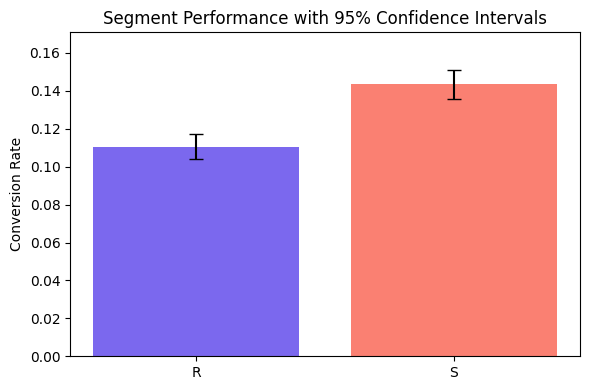

In [ ]:
plt.figure(figsize=(6, 4))

# Plot conversion rates with asymmetric error bars
plt.bar(
    conversion_summary['Segment'],
    conversion_summary['Conversion_Rate'],
    yerr=[
        conversion_summary['Conversion_Rate'] - conversion_summary['CI_Lower'],
        conversion_summary['CI_Upper'] - conversion_summary['Conversion_Rate']
    ],
    capsize=5,
    color=['mediumslateblue', 'salmon']
)

plt.ylabel('Conversion Rate')
plt.title('Segment Performance with 95% Confidence Intervals')
plt.ylim(0, max(conversion_summary['CI_Upper']) + 0.02)
plt.tight_layout()
plt.show()


**4. Two-Proportion Z-Test**

## Step 4: Statistical Hypothesis Testing Using Two-Proportion Z-Test

While visual comparison gives an intuitive sense of performance differences, formal validation requires statistical testing. In this step, we apply a two-proportion Z-test to determine whether the observed conversion rate for Segment S significantly exceeds that of Segment R, or whether the difference could simply be due to random variation.

The test begins with a null hypothesis that assumes no meaningful difference or lift between the two segments:

- **Null Hypothesis (H₀):** Segment S performs no better than Segment R  
- **Alternative Hypothesis (H₁):** Segment S exhibits a superior conversion rate

The Z-test uses the number of conversions and total visitors from each group to compute:
- A **Z-score**, representing how far apart the two conversion rates are in terms of standard deviations
- A **p-value**, indicating the probability of observing such a difference if the null hypothesis were true

If the p-value is below a predefined threshold (typically 0.05 for 95% confidence), we conclude that the lift from Segment S is statistically significant — i.e., unlikely to be random.

This step transforms observed results into actionable insights, allowing decision-makers to move forward with statistical backing. It strengthens experimental conclusions and helps avoid false positives, especially when visual overlap exists in confidence intervals.


In [ ]:
# Hypothesis: Segment S has higher conversion than Segment R
conversion_counts = np.array([segment_S_hits, segment_R_hits])
visitor_counts = np.array([segment_S_visitors, segment_R_visitors])

# Run one-sided two-proportion z-test
z_score, p_value = proportions_ztest(conversion_counts, visitor_counts, alternative='larger')

# Display test results
print(f"Z-score: {z_score:.3f}")
print(f"P-value: {p_value:.3f}")
if p_value < 0.05:
    print("→ Statistically significant uplift detected for Segment S.")
else:
    print("→ No statistically significant difference at 95% confidence level.")


Z-score: 6.451
P-value: 0.000
→ Statistically significant uplift detected for Segment S.


**5. Sequential (Real-Time) Monitoring Simulation**

## Step 5: Sequential Monitoring and Real-Time Inference

Modern experimentation often involves observing results dynamically as user data arrives in real-time. This step simulates a live testing scenario by feeding traffic in fixed-size batches — for example, 100 visitors per segment per cycle — and continuously updating performance metrics.

After each batch, cumulative conversions are tallied for Segment R and Segment S. Updated conversion rates (CR) are computed, followed by re-evaluation using the two-proportion Z-test. The output includes an evolving p-value (statistical significance) and a calculated uplift: the difference in CR between the test and reference segments.

These metrics are visualized using two plots:
- A **p-value trajectory** showing how statistical evidence grows (or fluctuates) over time
- A **conversion uplift chart** tracking changes in observed lift between segments

This approach is valuable in fast-moving contexts like product rollouts or marketing campaigns, where teams monitor metrics closely and want to act quickly. However, frequent significance checks can introduce bias — known as "peeking" — so appropriate safeguards (e.g. alpha correction or Bayesian methods) are recommended for real deployments.

Overall, sequential monitoring teaches how statistical certainty builds gradually and why early spikes may not always reflect stable improvements.


Step 60/60 | CR_R: 11.62%, CR_S: 13.50%, Lift: 1.88%
Z = 3.11, p = 0.0009
→ Significant


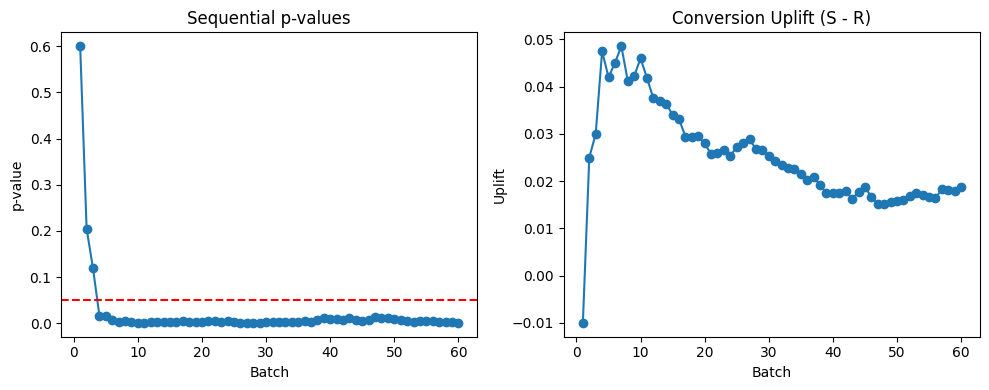

In [ ]:
import numpy as np, matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from IPython.display import clear_output

# Set parameters
prob_R, prob_S = 0.112, 0.136
batch_size, steps = 100, 60

# Counters
visits_R = visits_S = conversions_R = conversions_S = 0
batch_ids, pvals, lifts = [], [], []

for i in range(1, steps + 1):
    # Simulate one batch
    conversions_R += np.random.binomial(batch_size, prob_R)
    conversions_S += np.random.binomial(batch_size, prob_S)
    visits_R += batch_size
    visits_S += batch_size

    cr_R = conversions_R / visits_R
    cr_S = conversions_S / visits_S
    lift = cr_S - cr_R

    # Z-test
    conv_array = np.array([conversions_S, conversions_R])
    visitor_array = np.array([visits_S, visits_R])
    z, p = proportions_ztest(conv_array, visitor_array, alternative='larger')

    # Store results
    batch_ids.append(i)
    pvals.append(p)
    lifts.append(lift)

    # Display step summary
    clear_output(wait=True)
    print(f"Step {i}/{steps} | CR_R: {cr_R:.2%}, CR_S: {cr_S:.2%}, Lift: {lift:.2%}")
    print(f"Z = {z:.2f}, p = {p:.4f}")
    print("→ Significant" if p < 0.05 else "→ Not significant")

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(batch_ids, pvals, '-o'); ax[0].axhline(0.05, color='red', linestyle='--')
    ax[0].set_title("Sequential p-values"); ax[0].set_xlabel("Batch"); ax[0].set_ylabel("p-value")
    ax[1].plot(batch_ids, lifts, '-o')
    ax[1].set_title("Conversion Uplift (S - R)"); ax[1].set_xlabel("Batch"); ax[1].set_ylabel("Uplift")
    plt.tight_layout(); plt.show()


Cycle 60/60
Segment R → 678 conversions / 6000 visitors ⇒ CR = 11.300%
Segment S → 774 conversions / 6000 visitors ⇒ CR = 12.900%
Uplift: 1.600% | Z = 2.69 | p = 0.0036
→ Statistically significant uplift detected!


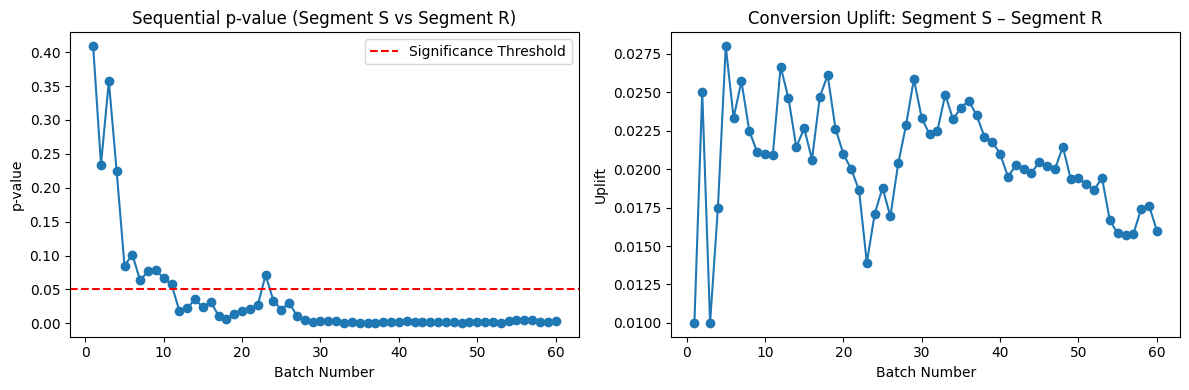

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from statsmodels.stats.proportion import proportions_ztest
from IPython.display import clear_output

# Define conversion probabilities and batch parameters
prob_R, prob_S = 0.112, 0.136
batch_size = 100
steps = 60

# Initialize counters
cumulative_R = cumulative_S = converted_R = converted_S = 0
batch_progress = []
sequential_pvals = []
dynamic_uplifts = []

# Real-time simulation loop
for cycle in range(1, steps + 1):
    # Simulate new conversions in this batch
    converted_R += np.random.binomial(batch_size, prob_R)
    converted_S += np.random.binomial(batch_size, prob_S)
    cumulative_R += batch_size
    cumulative_S += batch_size

    # Calculate conversion rates and uplift
    cr_R = converted_R / cumulative_R
    cr_S = converted_S / cumulative_S
    uplift = cr_S - cr_R

    # Z-test for statistical significance
    conv_array = np.array([converted_S, converted_R])
    visitor_array = np.array([cumulative_S, cumulative_R])
    z_stat, p_val = proportions_ztest(conv_array, visitor_array, alternative='larger')

    # Store tracking data
    batch_progress.append(cycle)
    sequential_pvals.append(p_val)
    dynamic_uplifts.append(uplift)

    # Display status
    clear_output(wait=True)
    print(f"Cycle {cycle}/{steps}")
    print(f"Segment R → {converted_R} conversions / {cumulative_R} visitors ⇒ CR = {cr_R:.3%}")
    print(f"Segment S → {converted_S} conversions / {cumulative_S} visitors ⇒ CR = {cr_S:.3%}")
    print(f"Uplift: {uplift:.3%} | Z = {z_stat:.2f} | p = {p_val:.4f}")
    print("→ Statistically significant uplift detected!" if p_val < 0.05 else "→ Not yet significant.")

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(batch_progress, sequential_pvals, '-o')
    axes[0].axhline(0.05, color='red', linestyle='--', label='Significance Threshold')
    axes[0].set_title('Sequential p-value (Segment S vs Segment R)')
    axes[0].set_xlabel('Batch Number')
    axes[0].set_ylabel('p-value')
    axes[0].legend()

    axes[1].plot(batch_progress, dynamic_uplifts, '-o')
    axes[1].set_title('Conversion Uplift: Segment S – Segment R')
    axes[1].set_xlabel('Batch Number')
    axes[1].set_ylabel('Uplift')

    plt.tight_layout()
    plt.show()
    time.sleep(0.2)
